![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Recurrent Neural Networks

Recurrent neural networks (RNN) are an extremely powerful tool in deep learning. These models quite accurately mimic how humans process information and learn. Unlike traditional feedforward neural networks, RNNs have memory. That is, information fed into them persists and the network is able to draw on this to make inferences.

##### Long Short-term Memory
Long Short-term Memory (LSTM) is a type of recurrent neural network. Instead of one layer, LSTM cells generally have four, three of which are part of "gates" -- ways to optionally let information through. The three gates are commonly referred to as the forget, input, and output gates. The forget gate layer is where the model decides what information to keep from prior states. At the input gate layer, the model decides which values to update. Finally, the output gate layer is where the final output of the cell state is decided. Essentially, LSTM separately decides what to remember and the rate at which it should update.

##### Financial Applications
LSTM models have produced some great results when applied to time-series prediction. One of the central challenges with conventional time-series models is that, despite trying to account for trends or other non-stationary elements, it is almost impossible to truly predict an outlier like a recession, flash crash, liquidity crisis, etc. By having a long memory, LSTM models are better able to capture these difficult trends in the data without suffering from the level of overfitting a conventional model would need in order to capture the same data.

For a very basic application, we're going to use a LSTM model to predict the price movement, a non-stationary time-series, of SPY.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import keras modules
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

qb = QuantBook()
symbol = qb.AddEquity("SPY").Symbol

# Fetch history
history = qb.History([symbol], 1280, Resolution.Daily)

# Fetch price
total_price = history.loc[symbol].close
training_price = history.loc[symbol].close[:1260]
test_price = history.loc[symbol].close[1260:]

# Transform price
price_array = np.array(training_price).reshape((len(training_price), 1))

Using TensorFlow backend.


In [2]:
# Scale data onto [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))

# Transform our data
spy_training_scaled = scaler.fit_transform(price_array)

# Build feauture and label sets (using number of steps 60, batch size 1200, and hidden size 1)
features_set = []
labels = []
for i in range(60, 1260):
    features_set.append(spy_training_scaled[i-60:i, 0])
    labels.append(spy_training_scaled[i, 0])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape

(1200, 60, 1)

In [3]:
# Build a Sequential keras model
model = Sequential()

# Add our first LSTM layer - 50 nodes
model.add(LSTM(units = 50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add additional layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# Fit the model to our data, running 50 training epochs
model.fit(features_set, labels, epochs = 50, batch_size = 32)


Epoch 1/50
1200/1200 [==============================] - 215s 180ms/step - loss: 0.0463 - mae: 0.1458 - acc: 0.0017
Epoch 2/50
1200/1200 [==============================] - 98s 82ms/step - loss: 0.0067 - mae: 0.0568 - acc: 0.0017
Epoch 3/50
1200/1200 [==============================] - 107s 89ms/step - loss: 0.0055 - mae: 0.0510 - acc: 0.0017
Epoch 4/50
1200/1200 [==============================] - 101s 84ms/step - loss: 0.0049 - mae: 0.0480 - acc: 0.0017
Epoch 5/50
1200/1200 [==============================] - 99s 82ms/step - loss: 0.0053 - mae: 0.0502 - acc: 0.0017
Epoch 6/50
1200/1200 [==============================] - 102s 85ms/step - loss: 0.0050 - mae: 0.0499 - acc: 0.0017
Epoch 7/50
1200/1200 [==============================] - 129s 108ms/step - loss: 0.0047 - mae: 0.0477 - acc: 0.0017
Epoch 8/50
1200/1200 [==============================] - 98s 82ms/step - loss: 0.0047 - mae: 0.0466 - acc: 0.0017
Epoch 9/50
1200/1200 [==============================] - 102s 85ms/step - loss: 0.0050 - 

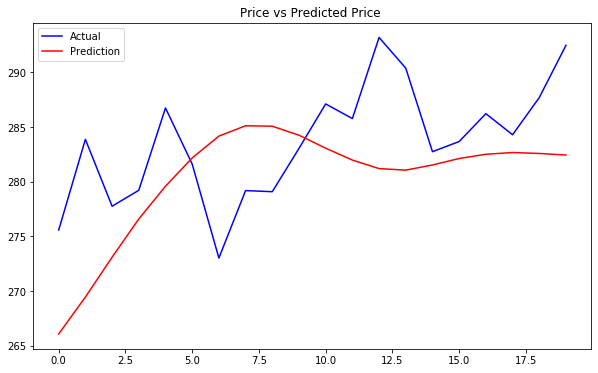

In [6]:
# Get and transform inputs for testing our predictions
test_inputs = total_price[-80:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

# Get test features
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# Make predictions
predictions = model.predict(test_features)

# Transform predictions back to original data-scale
predictions = scaler.inverse_transform(predictions)

# Plot our results!
plt.figure(figsize=(10,6))
plt.plot(test_price.values, color='blue', label='Actual')
plt.plot(predictions , color='red', label='Prediction')
plt.title('Price vs Predicted Price ')
plt.legend()
plt.show()